# 1주차 — 병 삼각형

## 학습 목표
- 기후변화가 병원체·기주·환경 상호작용에 미치는 영향 확인
  
- 실습 환경 세팅 및 데이터 미리보기

CWD: C:\Users\KKT-PC\Climate\climate-plant-health-course_starter_kit\notebooks
Python: 3.12.7  Matplotlib: 3.9.2
✔ Matplotlib 글꼴: Malgun Gothic
📄 데이터 파일: ..\data\sample_weather_2022.csv


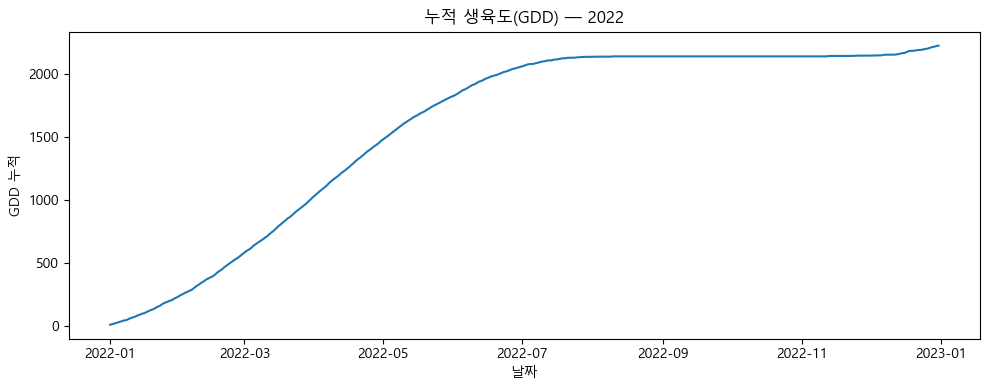

✅ 그림 저장: C:\Users\KKT-PC\Climate\climate-plant-health-course_starter_kit\notebooks\figs\01_gdd_cum.png


In [1]:
# ✅ 0) 기본 설정 & 진단
import os, sys
from pathlib import Path
import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib import font_manager

print("CWD:", os.getcwd())  # 현재 작업 폴더 확인
print("Python:", sys.version.split()[0], " Matplotlib:", mpl.__version__)

# ✅ 1) 한글 폰트 설정 (없으면 영어로 fallback)
candidates = [
    "Malgun Gothic",            # Windows 기본
    "NanumGothic", "Nanum Gothic",
    "Noto Sans CJK KR", "Noto Sans KR",
    "AppleGothic",
    "UnDotum", "Batang", "Gulim"
]
installed = {f.name for f in font_manager.fontManager.ttflist}
choice = next((c for c in candidates if c in installed), None)

if choice:
    mpl.rcParams["font.family"] = choice
    print("✔ Matplotlib 글꼴:", choice)
else:
    print("⚠ 한글 폰트 미탑재 → 제목/레이블은 영어로 대체 권장")

mpl.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지

# ✅ 2) utils 경로 추가 & 함수 임포트
UTILS_DIR = Path("..") / "utils"
if not UTILS_DIR.exists():
    # 노트북 실행 위치가 다를 수 있으니 대안 경로도 탐색
    alt = Path.cwd().resolve()
    tried = [UTILS_DIR, alt / "utils", alt.parent / "utils"]
    print("utils 탐색:", [str(p) for p in tried])
    for p in tried:
        if (p / "utils.py").exists():
            UTILS_DIR = p
            break
sys.path.append(str(UTILS_DIR))
from utils import growing_degree_days  # 실패하면 여기서 에러 메시지 확인

# ✅ 3) 데이터 경로 확인 & 로드
DATA_CANDIDATES = [
    Path("..") / "data" / "sample_weather_2022.csv",
    Path.cwd() / "data" / "sample_weather_2022.csv",
    Path.cwd().parent / "data" / "sample_weather_2022.csv",
]
data_path = next((p for p in DATA_CANDIDATES if p.exists()), None)
if data_path is None:
    # 폴더 전체에서 파일 찾기(최후의 수단)
    matches = list(Path.cwd().rglob("sample_weather_2022.csv"))
    if matches:
        data_path = matches[0]
        print("🔎 자동 탐색 경로:", data_path)
    else:
        raise FileNotFoundError("sample_weather_2022.csv 파일을 찾을 수 없습니다. 노트북의 실행 위치를 확인하세요.")

print("📄 데이터 파일:", data_path)

# parse_dates로 날짜 즉시 변환, 숫자 컬럼은 강제로 numeric 변환
weather = pd.read_csv(data_path)
if "date" in weather.columns:
    weather["date"] = pd.to_datetime(weather["date"], errors="coerce")

# 숫자 컬럼 강제 변환(문자/공백 등으로 인한 에러 방지)
for col in ["tmean_c", "prcp_mm", "rh_percent", "leaf_wetness_hours"]:
    if col in weather.columns:
        weather[col] = pd.to_numeric(weather[col], errors="coerce")

# 결측 간단 처리(필요 최소)
weather = weather.dropna(subset=["date", "tmean_c"]).sort_values("date").reset_index(drop=True)

# ✅ 4) GDD 계산
weather["gdd"] = growing_degree_days(weather["tmean_c"], base=10.0)
weather["gdd_cum"] = weather["gdd"].cumsum()

# ✅ 5) 시계열 플롯 (저장 + 표시)
plt.close("all")
plt.figure(figsize=(10, 4))
plt.plot(weather["date"], weather["gdd_cum"])
title_ko = "누적 생육도(GDD) — 2022"
plt.title(title_ko if choice else "Cumulative GDD — 2022")
plt.xlabel("날짜" if choice else "Date")
plt.ylabel("GDD 누적" if choice else "Cumulative GDD")
plt.tight_layout()

# 저장도 해두면, 노트북 미리보기/백엔드 이슈가 있어도 파일은 확인 가능
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
out_path = FIG_DIR / "01_gdd_cum.png"
plt.savefig(out_path, dpi=150)
plt.show()

print("✅ 그림 저장:", out_path.resolve())
